# Load in necessary packages

In [64]:
# Libraries required for moisture convergence visualization
from datetime import datetime
import numpy as np
import xarray as xr
import xwrf
import glob
import metpy.calc as mpcalc
import math

import matplotlib.pyplot as plt

### We will first identify LASSO SGP case(s) of interest

In [47]:
# Define path to the lasso simulation data
path_shcu_root = "/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/ShCu/untar"  # on Jupyter

#Define LASSO SGP case date and simulation of interest
case_date = datetime(2019, 4, 4) #Options[April 4, 2019; May 6, 2019]
sim_id = 4

#Load in LASSO wrfstat files. These provide 10-minute averages for various metorology variables and diagnostics
ds_stat = xr.open_dataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/raw_model/wrfstat_d01_{case_date:%Y-%m-%d_12:00:00}.nc")
#ds_stat

#Load in LASSO-ShCu wrfout data, which is raw simulation output from the Weather Research and Forecasting (WRF) model run in an idealized LES mode.
#Post process using xwrf package
ds = xr.open_mfdataset(f"{path_shcu_root}/{case_date:%Y%m%d}/sim{sim_id:04d}/raw_model/wrfout_d01_*.nc", combine="nested", concat_dim="Time").xwrf.postprocess()

# By default, xarray does not interpret the wrfout/wrfstat time information in a way that attaches 
# it to each variable. Here is a trick to map the time held in XTIME with the Time coordinate 
# associated with each variable.
ds_stat["Time"] = ds_stat["XTIME"]
ds["Time"] = ds["XTIME"]
ds

<xarray.Dataset> Size: 255GB
Dimensions:                    (Time: 91, y: 250, x: 250, soil_layers_stag: 5,
                                z: 226, x_stag: 251, y_stag: 251, z_stag: 227,
                                force_layers: 751)
Coordinates: (12/15)
    CLAT                       (y, x) float32 250kB dask.array<chunksize=(125, 125), meta=np.ndarray>
    XLAT                       (y, x) float32 250kB dask.array<chunksize=(125, 125), meta=np.ndarray>
    XLONG                      (y, x) float32 250kB dask.array<chunksize=(125, 125), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 728B dask.array<chunksize=(6,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 251kB dask.array<chunksize=(125, 126), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 251kB dask.array<chunksize=(125, 126), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 908B 1.0 0.9959 ... 0.002178 0.0
  * Time                       (Time) datetime64[ns] 728B 2019-04-04T12:00:00...
  * y_stag                     (y_stag) float64 2kB -1.25e+04 ... 1.25e+04
  * y                          (y) float64 2kB -1.245e+04 ... 1.245e+04
  * x                          (x) float64 2kB -1.245e+04 ... 1.245e+04
  * x_stag                     (x_stag) float64 2kB -1.25e+04 ... 1.25e+04
Dimensions without coordinates: soil_layers_stag, force_layers
Data variables: (12/251)
    Times                      (Time) |S19 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    ZS                         (Time, soil_layers_stag) float32 2kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    DZS                        (Time, soil_layers_stag) float32 2kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    U                          (Time, z, y, x_stag) float32 5GB dask.array<chunksize=(1, 226, 125, 126), meta=np.ndarray>
    ...                         ...
    geopotential               (Time, z_stag, y, x) float32 5GB dask.array<chunksize=(1, 227, 125, 125), meta=np.ndarray>
    geopotential_height        (Time, z_stag, y, x) float32 5GB dask.array<chunksize=(1, 227, 125, 125), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    wind_east_10               (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    wind_north_10              (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
Attributes: (12/142)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-04-04_12:00:00
    SIMULATION_START_DATE:                 2019-04-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1addhm
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov

### Moisture convergence requires U, V, and moisture Q. We load these in below:

In [119]:
#Load in u, v, and q data
U10 = ds["U10"]
V10 = ds["V10"]
QVAPOR = ds["QVAPOR"].sel(z=10, method='nearest').sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00")

#U and V have staggered x and y dimensions. The following unstaggers them to align with QVAPOR 
U = ds.U.interp(x_stag=ds.x)
V = ds.V.interp(y_stag=ds.y)

QVAPOR.shape

(250, 250)

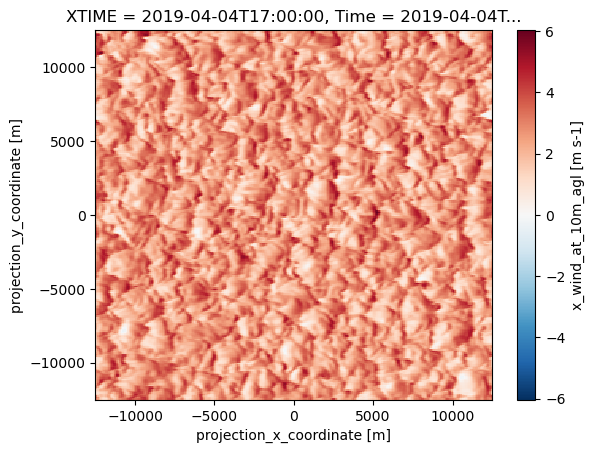

In [130]:
# We can use xarray's plotting features to get time-labeled plots.
hour_to_plot = 17 #UTC (6hrs after simulation start)

#This line shows the U winds at 10m from the surface at 18UTC
ds["U10"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00").plot()

/tmp/ipykernel_1554/326214781.py:4: UserWarning: More than one latitude coordinate present for variable .
  div = mpcalc.divergence(QVAPOR*ds["U10"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00"), QVAPOR*ds["V10"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00"))


Text(0.5, 1.0, 'Horizontal Moisture Divergence: 10m')

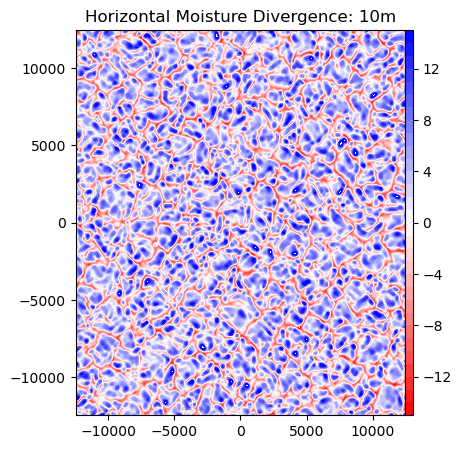

In [131]:
# Calculate the divergence of the flow
# Multiply by the water vapor (QVAPOR) to get the moisture divergenc

div = mpcalc.divergence(QVAPOR*ds["U10"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00"), QVAPOR*ds["V10"].sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00"))

# start figure and set axis
fig, ax = plt.subplots(figsize=(5, 5))

# plot divergence and scale by 1e5
cf = ax.contourf(ds.y, ds.x, div*1e5 , range(-15, 16, 1), cmap=plt.cm.bwr_r) #* 1e5
plt.colorbar(cf, pad=0, aspect=50)
#ax.barbs(ds.y.values, ds.x.values, ds.U10.sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00"), ds.V10.sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00"), color='black', length=0.5, alpha=0.5)
#ax.set(xlim=(260, 270), ylim=(30, 40))
ax.set_title('Horizontal Moisture Divergence: 10m')
#ax.set_

#plt.show()

### Moisture convergence at 1km

In [148]:
#Load in u, v, and q data
#U and V have staggered x and y dimensions. The following unstaggers them to align with QVAPOR 
U = ds.U.interp(x_stag=ds.x)
V = ds.V.interp(y_stag=ds.y)

z = 1000 

QVAPOR = ds["QVAPOR"].sel(z=z,method='nearest').sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00")
QVAPOR.shape

(250, 250)

In [149]:
U_at_z = U.sel(z=z,method='nearest').sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00")
V_at_z = V.sel(z=z,method='nearest').sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00")

print(U_at_z.shape)
print(V_at_z.shape)

(250, 250)
(250, 250)


/tmp/ipykernel_1554/3030828318.py:4: UserWarning: More than one longitude coordinate present for variable .
  div2 = mpcalc.divergence(QVAPOR*U_at_z, QVAPOR*V_at_z)
/tmp/ipykernel_1554/3030828318.py:4: UserWarning: More than one latitude coordinate present for variable .
  div2 = mpcalc.divergence(QVAPOR*U_at_z, QVAPOR*V_at_z)
/tmp/ipykernel_1554/3030828318.py:4: UserWarning: More than one time coordinate present for variable .
  div2 = mpcalc.divergence(QVAPOR*U_at_z, QVAPOR*V_at_z)


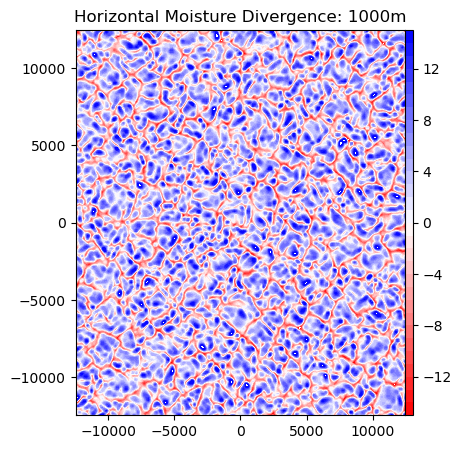

In [150]:
# Calculate the divergence of the flow
# Multiply by the water vapor (QVAPOR) to get the moisture divergenc

div2 = mpcalc.divergence(QVAPOR*U_at_z, QVAPOR*V_at_z)

# start figure and set axis
fig2, ax = plt.subplots(figsize=(5, 5))

# plot divergence and scale by 1e5
cf = ax.contourf(ds.y, ds.x, div2*1e5 , range(-15, 16, 1), cmap=plt.cm.bwr_r) #* 1e5
plt.colorbar(cf, pad=0, aspect=50)
#ax.barbs(ds.y.values, ds.x.values, ds.U10.sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00"), ds.V10.sel(Time=f"{case_date:%Y-%m-%d} {hour_to_plot}:00"), color='black', length=0.5, alpha=0.5)
#ax.set(xlim=(260, 270), ylim=(30, 40))
ax.set_title('Horizontal Moisture Divergence: 1000m')


plt.show()

In [144]:
ds

<xarray.Dataset> Size: 255GB
Dimensions:                    (Time: 91, y: 250, x: 250, soil_layers_stag: 5,
                                z: 226, x_stag: 251, y_stag: 251, z_stag: 227,
                                force_layers: 751)
Coordinates: (12/15)
    CLAT                       (y, x) float32 250kB dask.array<chunksize=(125, 125), meta=np.ndarray>
    XLAT                       (y, x) float32 250kB dask.array<chunksize=(125, 125), meta=np.ndarray>
    XLONG                      (y, x) float32 250kB dask.array<chunksize=(125, 125), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 728B dask.array<chunksize=(6,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 251kB dask.array<chunksize=(125, 126), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 251kB dask.array<chunksize=(125, 126), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 908B 1.0 0.9959 ... 0.002178 0.0
  * Time                       (Time) datetime64[ns] 728B 2019-04-04T12:00:00...
  * y_stag                     (y_stag) float64 2kB -1.25e+04 ... 1.25e+04
  * y                          (y) float64 2kB -1.245e+04 ... 1.245e+04
  * x                          (x) float64 2kB -1.245e+04 ... 1.245e+04
  * x_stag                     (x_stag) float64 2kB -1.25e+04 ... 1.25e+04
Dimensions without coordinates: soil_layers_stag, force_layers
Data variables: (12/251)
    Times                      (Time) |S19 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    ZS                         (Time, soil_layers_stag) float32 2kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    DZS                        (Time, soil_layers_stag) float32 2kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    U                          (Time, z, y, x_stag) float32 5GB dask.array<chunksize=(1, 226, 125, 126), meta=np.ndarray>
    ...                         ...
    geopotential               (Time, z_stag, y, x) float32 5GB dask.array<chunksize=(1, 227, 125, 125), meta=np.ndarray>
    geopotential_height        (Time, z_stag, y, x) float32 5GB dask.array<chunksize=(1, 227, 125, 125), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 5GB dask.array<chunksize=(1, 226, 125, 125), meta=np.ndarray>
    wind_east_10               (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
    wind_north_10              (Time, y, x) float32 23MB dask.array<chunksize=(1, 125, 125), meta=np.ndarray>
Attributes: (12/142)
    TITLE:                                  OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                            2019-04-04_12:00:00
    SIMULATION_START_DATE:                 2019-04-04_12:00:00
    WEST-EAST_GRID_DIMENSION:              251
    SOUTH-NORTH_GRID_DIMENSION:            251
    BOTTOM-TOP_GRID_DIMENSION:             227
    ...                                    ...
    config_aerosol:                        NA
    config_forecast_time:                  15.0 h
    config_boundary_method:                Periodic
    config_microphysics:                   Thompson (mp_physics=8)
    config_nickname:                       runlas20190404v1addhm
    simulation_origin_host:                cumulus-login2.ccs.ornl.gov